In [2]:
from brian2 import *
from DynapSE import DynapSE
from scipy import signal
import matplotlib.pyplot as plt

In [3]:
# to start a new build to run multiple full simulations
device.reinit()
device.activate()
# need to reset the defaultclock after activate
defaultclock.dt = 20 * us

duration = 4 * second

network = Network()
chip = DynapSE(network)

input_frequencies = [300, 400]



indices = []
times = []
for i, freq in enumerate(input_frequencies):
    noise_mean = 1 / freq
    noise_std = 1 / freq / 8
    timesteps = int(freq * duration / second)
    indices = np.concatenate([indices, np.ones(timesteps) * i], axis=0)
    times = np.concatenate([
        times,
        np.arange(0, 4, 1 / freq)# + np.random.normal(noise_mean, noise_std, timesteps)
    ], axis=0)

spike_generator = SpikeGeneratorGroup(len(input_frequencies), indices, times * second)

DPI_neuron  = chip.get_neurons(1, 'Core_1')

DPI_synapse = chip.add_connection(spike_generator, DPI_neuron, synapse_type='AMPA')

chip.connect(DPI_synapse, True)
DPI_synapse.weight = 300

# TODO: tune the parameters to make the neuron fire at 10 Hz
############### TODO: set the parameters ###################
ampa_conf = {"I_tau_syn_exc2": 10 * pA}
chip.set_param(ampa_conf, 'Core_1')

############### TODO: set the parameters ###################

# monitors
mon_synapse_state = StateMonitor(DPI_synapse, 'I_syn_exc2', record=True)
mon_neuron_state  = StateMonitor(DPI_neuron,  'Imem', record=True)
mon_neuron_input  = SpikeMonitor(spike_generator, name='mon_neuron_input')
mon_neuron_output = SpikeMonitor(DPI_neuron, name='mon_neuron_output')

# add all the instances into the network
network.add([spike_generator, DPI_neuron, DPI_synapse, 
             mon_synapse_state, mon_neuron_state, mon_neuron_input, mon_neuron_output])

# Simulation
network.run(duration)

1 neurons are allocated from Core_1.
New parameter values are loaded to Core_1.


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: "I_syn_exc2_post += ((I_wo_syn_exc2_post * weight) * I_g_syn_exc2_post) / (I_tau_syn_exc2_post * (1.0 + (I_g_syn_exc2_post / I_syn_exc2_post))) (in-place)"
 [brian2.codegen.generators.base]


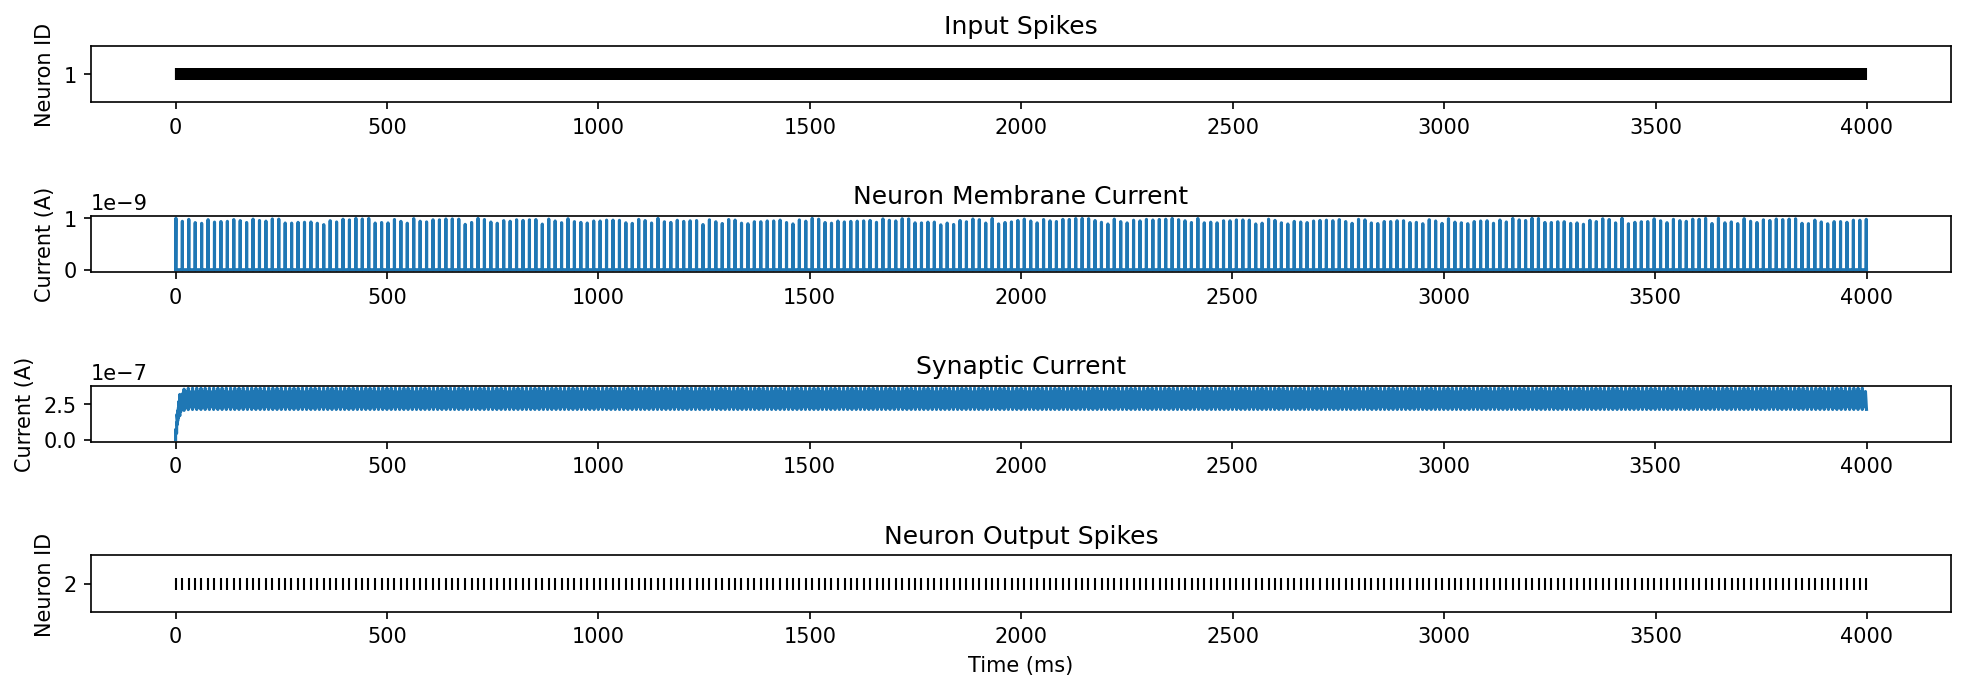

In [4]:
# plotting
plt.figure(figsize=(16,5),dpi=150)
plt.subplots_adjust(hspace=2)

times = int(duration/ms)

# Input Spikes 
plt.subplot(411)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_input.t/ms, dtype=int)]=1
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(0.5, 1.5)
plt.title('Input Spikes')
plt.ylabel('Neuron ID')
#plt.xlabel('Time (ms)')

plt.subplot(412)
Imem = mon_neuron_state.Imem[0]
plt.plot(mon_neuron_state.t/ms, Imem)

plt.title('Neuron Membrane Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(413)
I_syn = mon_synapse_state.I_syn_exc2[0]
plt.plot(mon_neuron_state.t/ms, I_syn)

plt.title('Synaptic Current')
plt.ylabel('Current (A)')
#plt.xlabel('Time (ms)')

plt.subplot(414)
spike_placeholder = np.zeros(times)
spike_placeholder[np.array(mon_neuron_output.t/ms, dtype=int)]=2
plt.plot(spike_placeholder,'k|')
matplotlib.pyplot.yticks(range(1, 3))
plt.ylim(1.5, 2.5)
plt.title('Neuron Output Spikes')
plt.ylabel('Neuron ID')
plt.xlabel('Time (ms)')
plt.show()

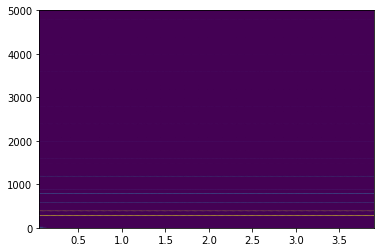

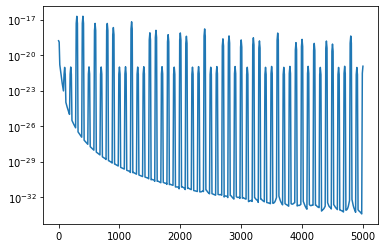

In [5]:
ts = mon_synapse_state.I_syn_exc2[0]
#ts = mon_neuron_state.Imem[0]
ts = ts - ts.mean()
fs = 10e5 / defaultclock.dt * us
nperseg = 5000

f, t, Sxx = signal.spectrogram(ts, fs, nperseg=nperseg)
_, Pxx_den = signal.welch(ts, fs, nperseg=nperseg)

fmin = 0 # Hz
fmax = 5000 # Hz
freq_slice = np.where((f >= fmin) & (f <= fmax))

# keep only frequencies of interest
f   = f[freq_slice]
Sxx = Sxx[freq_slice,:][0]
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.show()


Pxx_den = Pxx_den[freq_slice]
plt.semilogy(f, Pxx_den)
plt.show()

In [6]:
import pyaudio

p = pyaudio.PyAudio()

volume = 5000000
fs = int(10e5 / 20)     # sampling rate, Hz, must be integer

ts_sample = (ts * volume).astype(np.float32).tobytes()

# for paFloat32 sample values must be in range [-1.0, 1.0]
stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=fs,
                output=True)

# play. May repeat with different volume values (if done interactively) 
stream.write(ts_sample)

stream.stop_stream()
stream.close()

p.terminate()

ModuleNotFoundError: No module named 'pyaudio'